## Effect of Warmstarting the Hyperparameter Search

Before adding hyperparameter search option to the Experiment Graph, we perform a simple analysis where we select the one pipeline and for every execution we add the hyperparameters and the final accuracy to the Trial object of the hypernet. Afterwards, we perform a search using a predefined budget to find the best set of parameters.
We compare the result, with the vanilla version, where the Trial object is empty and report the quality and time to achieve the certain level of quality.

In [84]:
from openml import datasets, tasks, runs, flows, setups, config, evaluations
from workloadoptimization.essentials import Component, ExperimentObject, ExperimentGraph, ExperimentParser
from workloadoptimization.hyperopt_helper import TrialConverter
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import uuid
import networkx as nx
import sklearn
from networkx.drawing.nx_agraph import graphviz_layout
from openmlstudy14.preprocessing import ConditionalImputer
from matplotlib2tikz import save as tikz_save
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

In [2]:
flow = flows.get_flow(flow_id=7707)
task = tasks.get_task(task_id=31)
pipeline = flows.flow_to_sklearn(flow)

In [3]:
import pickle
def getTopRuns(numberOfRuns, pipeline, task):
    openMlEvaluations = evaluations.list_evaluations('predictive_accuracy', task= [task], flow = [pipeline])
    evaluationData = pd.DataFrame.from_dict(openMlEvaluations, orient='index')
    evaluationData['accuracy'] = evaluationData.apply(lambda eva: eva.values[0].value, axis = 1)
    evaluationData['run_id'] = evaluationData.apply(lambda eva: eva.values[0].run_id, axis = 1)
    # extracting the top ''numberOfRuns' runs
    topRuns = evaluationData.sort_values('accuracy',ascending=False)
    if (numberOfRuns>0):
        topRuns = topRuns[0:numberOfRuns]
    # retreiving the run objects from the top runs
    openMLRuns = runs.list_runs(task=[task], flow=[pipeline])
    experiments = pd.DataFrame.from_dict(openMLRuns,orient='index')
    Experiment = experiments.merge(topRuns,on='run_id').drop(columns=['uploader',0])
    # TODO: This is the limit on the api size, I should fix it to make calls in batches
    Setup = pd.DataFrame.from_dict(setups.list_setups(setup=Experiment.setup_id[0:500], size = 500 ), orient='index').reset_index()
    Setup.columns=['id', 'setup']

    return pd.merge(Setup, Experiment, how = 'inner', left_on='id', right_on='setup_id').drop(columns = ['id','setup_id'])[['run_id','task_id','flow_id', 'accuracy','setup']]
def extractExperiments(filePath, taskIds, flowIds):
    if os.path.isfile(filePath):
        return pd.read_pickle(filePath)
    frames = []
    for t in taskIds:
        for f in flowIds:
            frames.append(getTopRuns(100000,f,t))
    Experiments = pd.concat(frames).reset_index(drop=True)
    Experiments.to_pickle(filePath)
    return Experiments

# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extractExperiments('meta/hyper-opt-experiment-31-7707', [31], [7707])


In [4]:
OPENML_FLOWS = {}
FLOW_IDS = Experiments.flow_id.unique()
for f in FLOW_IDS:
    try:
        #print f
        fl = flows.get_flow(f)
        OPENML_FLOWS[f] = fl 
    except:
        print 'error for {}'.format(f)
parser = ExperimentParser()
experimentObjects = parser.extractOpenMLFlows(Experiments, OPENML_FLOWS)

In [5]:
# Find the range of all the hyperparameters for setting up the search space
param_range = {}
for e in experimentObjects:
    for k,v in e.extractParams().iteritems():
        if param_range.has_key(k):
            param_range[k].append(v)
        else:
            param_range[k] = [v]

In [6]:
# Find the hyperparameters with constant values so we can set them once and do not include them in the search space
CONSTANT_PARAMS = {}
DYNAMIC_PARAMS = []
for k in param_range.keys():
    try:
        size = len(set(param_range[k]))
        if size == 1:
            CONSTANT_PARAMS[k] = param_range[k][0]
        else:
            DYNAMIC_PARAMS.append(k)
    except: 
        CONSTANT_PARAMS[k] = param_range[k][0]    
        #print k,'error'
print 'Dynamic hyperparameters: {}'.format(DYNAMIC_PARAMS)

Dynamic hyperparameters: ['classifier__tol', 'classifier__gamma', 'classifier__C', 'imputation__strategy', 'classifier__degree', 'classifier__coef0', 'classifier__shrinking', 'classifier__kernel']


Based on the list of the parameters in the experiments these are the feasable ranges (or categories) of the parameters.
- classifier__tol 1.0509652110524482e-05 0.09706102908291375
- classifier__gamma 3.122280314190532e-05 7.998532268538166
- classifier__C 0.03213680700039348 32547.418063576853
- imputation__strategy {u'"mean"', u'"median"', u'"most_frequent"'}
- classifier__degree {u'1', u'2', u'3', u'4', u'5'}
- classifier__coef0 -0.9942534412466477 0.9975887639931769
- classifier__shrinking True, False

In [7]:
# construct the search space
from hyperopt import hp

# Parameter search space
space = {}
# between 1.0509652110524482e-05 0.09706102908291375
space['classifier__tol'] = hp.lognormal('classifier__tol',-7, 1)
# between 3.122280314190532e-05 7.998532268538166
space['classifier__gamma'] = hp.lognormal('classifier__gamma',0.0001, 1.3)
# One of True or False
space['classifier__C'] = hp.lognormal('classifier__C',2.5, 3)
# choice
space['imputation__strategy'] = hp.choice('imputation__strategy', [u'mean', u'median', u'most_frequent'])
# choice
space['classifier__degree'] = hp.choice('classifier__degree', [1, 2, 3, 4, 5])
# Between -0.9942534412466477 0.9975887639931769
space['classifier__coef0'] = hp.uniform('classifier__coef0', -1, 1)
# True or False
space['classifier__shrinking'] = hp.choice('classifier__shrinking',[True, False])

In [8]:
# set the constant parameters and define the objective function
pipeline.set_params(**CONSTANT_PARAMS)
def objective(params):
    #print params
    pipeline.set_params(**params)
    try:
        pipeline.fit(X_train, y_train)
    except:
        print 'Error for the params: {}'.format(params)
    accuracy = pipeline.score(X_test, y_test)
    #print 'accuracy = {}'.format(accuracy)
    return 1 - accuracy

In [9]:
# load the dataset
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices,test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
target=dataset.default_target_attribute,
return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

In [61]:
# sort based on the loss
sortedObjects = sorted(experimentObjects, key=lambda eo: 1 - eo.quality, reverse=True)

In [190]:
trialConverter = TrialConverter()
warmTrials = trialConverter.trialsFromExperimentObjects(space, sortedObjects)
INITIAL_SIZE = len(warmTrials.trials)

In [63]:
# start the search process with trials database already set
from hyperopt import fmin, tpe, Trials, rand

# Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=600,
            trials=warmTrials)

In [64]:
# start the search process with trials database already set
from hyperopt import fmin, tpe, Trials, rand

coldTrials = Trials()
# Run the hyperparameter search using the tpe algorithm
best = fmin(objective,
            space,
            algo=tpe.suggest,
            max_evals=100,
            trials=coldTrials)

In [ ]:
def drawPlots(targetTrial):
    plt.figure(figsize=(10,10))
    plt.subplot(3,3,1)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__tol'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__tol')
    plt.subplot(3,3,2)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__gamma'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__gamma')
    plt.subplot(3,3,3)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__C'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__C')
    plt.subplot(3,3,4)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__degree'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__degree')
    plt.subplot(3,3,5)
    ax = sns.regplot(x = np.array([x['misc']['vals']['classifier__coef0'][0] for x in targetTrial.trials]), y = np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('classifier__coef0')
    plt.subplot(3,1,3)
    ax = sns.regplot(np.array(range(len(targetTrial.losses()))), np.array(targetTrial.losses()), fit_reg=False)
    ax.set_title('Trials vs Quality over time')

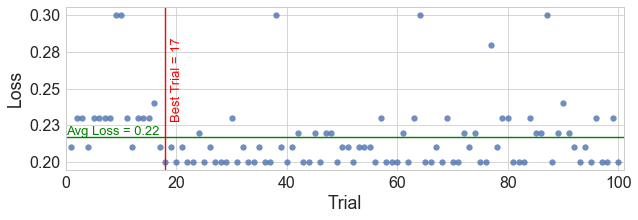

In [283]:
from matplotlib.ticker import FormatStrFormatter
# Warmstarting
trials = Trials()
trials.insert_trial_docs(warmTrials.trials[500:])
trials.refresh()
TRIALS_SIZE = len(trials.losses())
plt.figure(figsize=(10,3))
ax = sns.regplot(np.array(range(1, len(trials.losses()) + 1)), np.array(trials.losses()), fit_reg=False, scatter_kws={'s': 40})
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylabel('Loss')
ax.set_xlabel('Trial')
ax.set_xlim(0,TRIALS_SIZE + 1)

# Show the average loss
avgLoss = np.mean(trials.losses())
plt.text(s='Avg Loss = {0:.2f}'.format(avgLoss),x=0, y=avgLoss + 0.002, fontdict={'size':13, 'color':'green'})
plt.hlines(xmin=0, xmax=len(trials.losses())+1, y = avgLoss, colors ='green')

# Show the first best model
idxOfBest = trials.best_trial['tid'] - INITIAL_SIZE 
y0,y1 =  ax.get_ylim()
plt.vlines(ymin=y0, ymax=y1, x=idxOfBest + 1, colors='red')
plt.text(s='Best Trial = {}'.format(idxOfBest), x=idxOfBest + 2, y= (y0+y1)/2.2, fontdict={'size':13,
                                                                                  'color':'red', 
                                                                                  'Rotation':'90',
                                                                                  'VerticalAlignment':'bottom'})
ax.set_ylim(y0,y1)

plt.savefig('figures/warm-starting-warm500-trials100-task31.eps', format='eps', dpi=1000, bbox_inches='tight')
#tikz_save('figures/warm-starting-warm500-trials100-task31.eps')

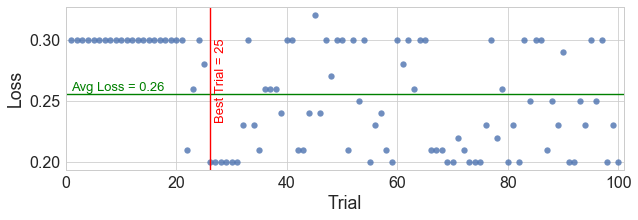

In [284]:
# Cold Starting
plt.figure(figsize=(10,3))
TRIALS_SIZE = len(coldTrials.losses())
ax = sns.regplot(np.array(range(1, TRIALS_SIZE + 1)), np.array(coldTrials.losses()), fit_reg=False, scatter_kws={'s': 40})
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_ylabel('Loss')
ax.set_xlabel('Trial')
ax.set_xlim(0,TRIALS_SIZE + 1)
# Show the average loss
avgLoss = np.mean(coldTrials.losses())
plt.text(s='Avg Loss = {0:.2f}'.format(avgLoss),x=1, y=avgLoss + 0.002, fontdict={'size':13, 'color':'green'})
plt.hlines(xmin=0, xmax=TRIALS_SIZE+1, y = avgLoss, colors ='green')

# Show the first best model
idxOfBest = coldTrials.best_trial['tid'] 
y0,y1 =  ax.get_ylim()
plt.vlines(ymin=y0, ymax=y1, x=idxOfBest + 1, colors='red')
plt.text(s='Best Trial = {}'.format(idxOfBest), x=idxOfBest + 2, y= (y0+y1)/2.24, fontdict={'size':13,
                                                                                  'color':'red', 
                                                                                  'Rotation':'90',
                                                                                  'VerticalAlignment':'bottom'})
ax.set_ylim(y0,y1)

plt.savefig('figures/cold-starting-trials100-task31.eps', format='eps', dpi=1000, bbox_inches='tight')
#tikz_save('figures/cold-starting-trials100-task31')

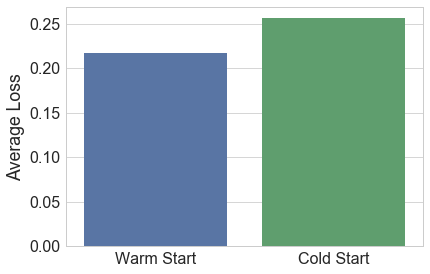

In [114]:
ax = sns.barplot(x = ['Warm Start', 'Cold Start'], y = [np.mean(trials.losses()), np.mean(coldTrials.losses())])
ax.set_ylabel('Average Loss')
plt.savefig('figures/warm-vs-cold-task31.eps', format='eps', dpi=1000, bbox_inches='tight')
#tikz_save('figures/warm-vs-cold-task31')

## Comparison of the Accuracy for Warm and Cold Trials
In the experiment, we warm started the Trials object with 500 points from the OpenML repository and run the optimization process 100 times.
Figure above shows that using the existing experiments to warm start the Trials object for the bayesian optimization reduces the average loss of the subsequent trials (cold start = 0.256, warm start = 0.217).
Moreover, the best result (0.20) was found slightly earlier in warm start (after 17 iterations) when compared to the cold start (25 iterations).
However, running the experiments for longer trials (500) sometimes results in cold start achieving a better result. I believe, wamr starting results in local minima and forces the search to focus more on exploitation rather than exploration.
We should address the problem of local minima and propose solutions for fixing it.


## Conclusion
Warm starting for bayesian optimization certainly shows promising result. We must address some of its issues and perform more experiments on different datasets and pipelines.